# This Kaggle notebook includes code to do ensemble learning after extracting features using CheXNet and DenseNet 169 Model, Inception Net and hand crafted features like HOG and GIST after doing rotation invariant augmentation on the input data.



***Steps to get started***

Execute this notebook in Kaggle. 
Login to Kaggle account and click on "New Notebook".
From File menu, select "Import notebook", and drag and drop this notebook file to it.
Click on any cell to start session.
On the right pane, you will find "Add Data" . On the search icon give the below url (of the dataset) and select this dataset from the search results. Click the "+" icon to add this dataset to your notebook session.

Dataset - https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')



In [3]:
os.listdir('../input/pulmonary-chest-xray-abnormalities')

['ChinaSet_AllFiles', 'Montgomery']

In [4]:
shen_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

In [5]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

""" creates two pandas dataframes, df_shen and df_mont, with one column each, 'image_id', 
which contain the list of image names for each dataset. 
The dataframes df_shen and df_mont will be used to store information about the images and 
their respective categories, if any."""

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
"""The inplace argument is set to True to modify the dataframe in place, without returning a new dataframe. 
The drop argument is set to True to drop the original index, and replace it with the default integer index."""
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [6]:
df_shen.head()

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png


In [7]:
df_mont.head()

,image_id
0,MCUCXR_0017_0.png
1,MCUCXR_0020_0.png
2,MCUCXR_0030_0.png
3,MCUCXR_0013_0.png
4,MCUCXR_0354_1.png


In [8]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.


def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

""" The function extract_target takes a file name string as input and returns a string 'Normal' or 
'Tuberculosis' based on the last 5 characters of the file name."""


" The function extract_target takes a file name string as input and returns a string 'Normal' or \n'Tuberculosis' based on the last 5 characters of the file name."

In [9]:
# Assign the target labels

'''This code is using the apply method of the pandas DataFrame df_shen and df_mont to 
apply the extract_target function to each image_id in the data frames. 
The result of the function is stored in a new column target in each data frame. 
'''

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [10]:
# Shenzen Dataset

df_shen['target'].value_counts()

"""Returns the count of each unique value of the target column in the df_shen DataFrame. 
The result is a new pandas Series with index being the unique values of the target column and values being 
their corresponding counts."""

'Returns the count of each unique value of the target column in the df_shen DataFrame. \nThe result is a new pandas Series with index being the unique values of the target column and values being \ntheir corresponding counts.'

In [11]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

Function to display the images in datasets

In [12]:
def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    """This function uses the Matplotlib library to display a sample of images from a dataframe. 
    The function takes the following parameters: 

col_name: the name of the column in the dataframe that will be used to group the data by category.

figure_cols: the number of columns in the figure that will be displayed. 
This value will also be used as the sample size for each category.

df: the dataframe that contains the data to be displayed.

IMAGE_PATH: the path to the directory where the images are stored.
The function starts by grouping the data in the dataframe by category and getting a list of unique categories. 
Then, a figure is created with a number of rows equal to the number of categories and a number of columns equal to 
figure_cols.

For each category, a random sample of size figure_cols is taken from the dataframe, and the corresponding images are displayed in the figure. The title of each image is set to the category name.

The plt.tight_layout() function is used to automatically adjust the subplot parameters to give the best fit. Finally, the plt.show() function is used to display the figure.
"""
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

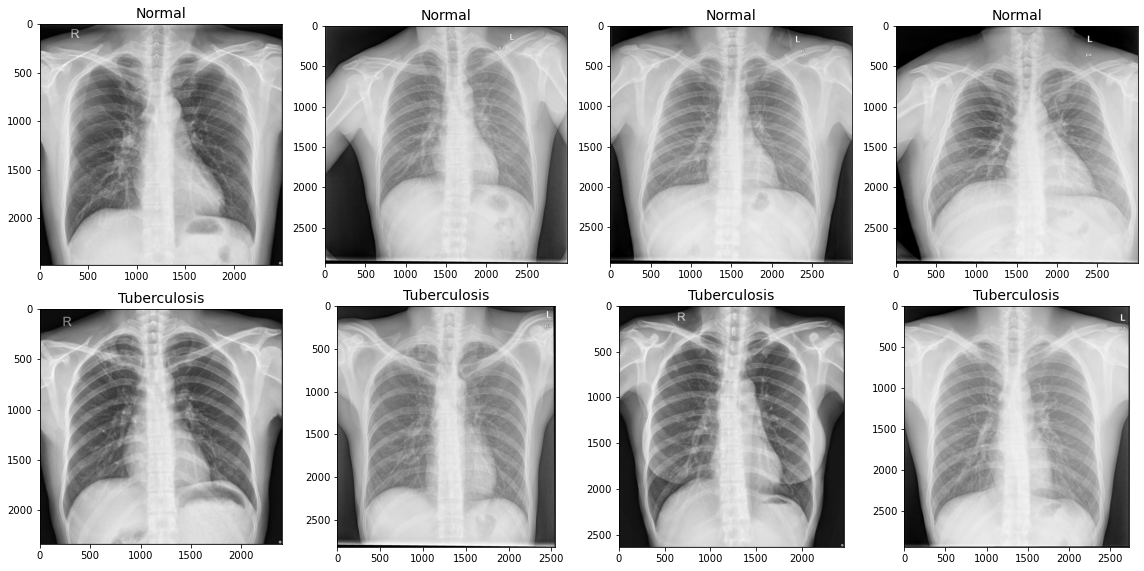

In [13]:
# Shenzen Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

Visualizing the Montgomery dataset images

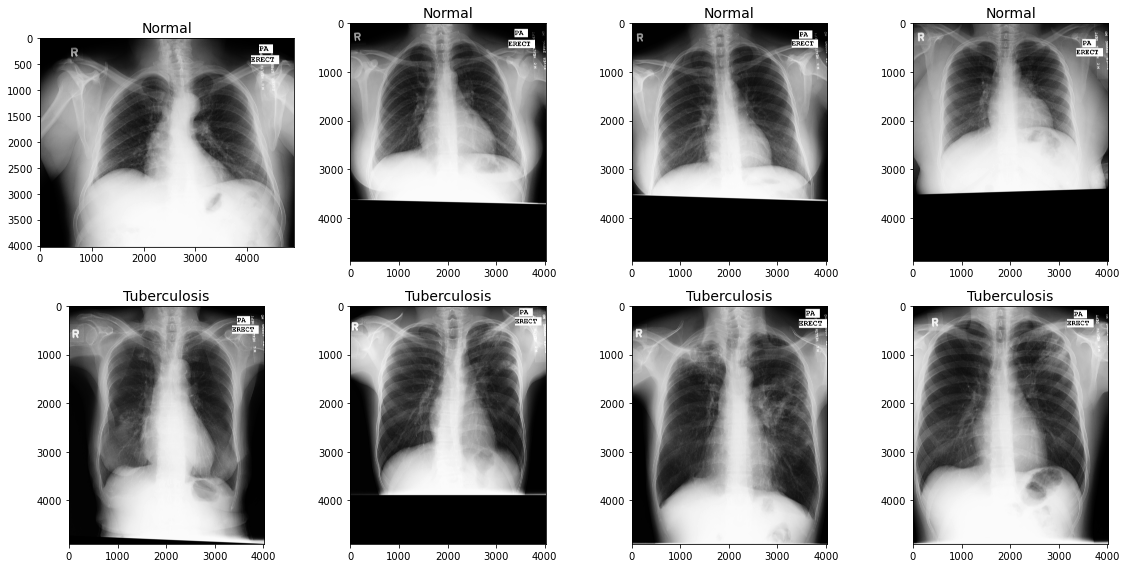

In [14]:
# Montgomery Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

# EDA Exploratory Data Analysis

In [15]:
"""The function read_image_sizes is used to obtain information about the images stored in a given file. The function takes the filename of an image as input and returns the height, width, number of channels, maximum pixel value and minimum pixel value of that image.

First, the function reads the image file using the cv2.imread function from the OpenCV library.

The maximum and minimum pixel values of the image are obtained using the max and min functions respectively.

The shape of the image is obtained using the image.shape property. The shape is a tuple that represents the height, 
width and number of channels of the image.

If the number of elements in the shape tuple is greater than 2, then the image has three channels (red, green, blue),
and the height, width and number of channels are added to the output list.

If the number of elements in the shape tuple is 2, then the image has only one channel (grayscale), and the height, 
width and a value of 1 (representing one channel) are added to the output list.

Finally, the output list containing the image information is returned by the function."""

'The function read_image_sizes is used to obtain information about the images stored in a given file. The function takes the filename of an image as input and returns the height, width, number of channels, maximum pixel value and minimum pixel value of that image.\n\nFirst, the function reads the image file using the cv2.imread function from the OpenCV library.\n\nThe maximum and minimum pixel values of the image are obtained using the max and min functions respectively.\n\nThe shape of the image is obtained using the image.shape property. The shape is a tuple that represents the height, \nwidth and number of channels of the image.\n\nIf the number of elements in the shape tuple is greater than 2, then the image has three channels (red, green, blue),\nand the height, width and number of channels are added to the output list.\n\nIf the number of elements in the shape tuple is 2, then the image has only one channel (grayscale), and the height, \nwidth and a value of 1 (representing one c

In [16]:
#EDA
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output


In [17]:
# w = width, h= height, c= number of channels of image
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0092_0.png,Normal,2652,2796,3,255,0
1,CHNCXR_0322_0.png,Normal,2949,3000,3,255,0
2,CHNCXR_0304_0.png,Normal,2945,3000,3,255,0
3,CHNCXR_0572_1.png,Tuberculosis,2289,2400,3,255,0
4,CHNCXR_0547_1.png,Tuberculosis,2823,2610,3,255,0


In [18]:
# w = width, h= height, c= number of channels of image; for Montgomery
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0017_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0020_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0030_0.png,Normal,4020,4892,3,255,0
3,MCUCXR_0013_0.png,Normal,4020,4892,3,255,0
4,MCUCXR_0354_1.png,Tuberculosis,4020,4892,3,252,0


In [19]:
df_shen['c'].value_counts() 
# This will return a series object that contains the count of unique values 
#in the 'c' column of df_shen.

3    662
Name: c, dtype: int64

In [20]:
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

In [21]:
df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [22]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

Label creation

In [23]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [24]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
493,CHNCXR_0019_0.png,Normal,2941,3000,3,255,6,0
341,CHNCXR_0395_1.png,Tuberculosis,2904,2715,3,255,0,1
387,CHNCXR_0204_0.png,Normal,2990,2987,3,255,0,0
304,CHNCXR_0046_0.png,Normal,2931,3000,3,255,0,0
671,MCUCXR_0043_0.png,Normal,4020,4892,3,255,0,0


Splitting data into train and test split

In [25]:
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [26]:
df_train['target'].value_counts()

Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [27]:
df_train.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
433,CHNCXR_0363_1.png,Tuberculosis,2788,2460,3,255,0,1
551,CHNCXR_0159_0.png,Normal,2989,2991,3,255,0,0
85,CHNCXR_0589_1.png,Tuberculosis,2645,2421,3,255,0,1
78,CHNCXR_0578_1.png,Tuberculosis,2990,2903,3,255,0,1
530,CHNCXR_0450_1.png,Tuberculosis,2945,2992,3,255,0,1


In [28]:
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

CREATE FOLDERS INSIDE THE BASE DIRECTORY - to arrange train images and validation images in respective folders

In [29]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


In [30]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [31]:
# We will resize the images to 299 x 299 as expected by the Inception model.
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299

In [32]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [33]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

345
335


In [34]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


# Rotation Invariant Augmentation in one step, without using keras aug steps

In [35]:
import os
import random
import numpy as np
from scipy import ndarray

# image processing library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import cv2
import skimage.io
import skimage.transform

def gkernel(l=3, sig=0.3):
    """\
    Gaussian Kernel Creator via given length and sigma
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)



def shear(image_array: ndarray):
  rows, cols, dim = image_array.shape
  # transformation matrix for Shearing
  # shearing applied to x-axis
  # shear value as given in paper 0.2 and 0.4
  M = np.float32([[1, 0, 0],
              [0.2, 1  , 0],
              [0, 0  , 1]])
  # shearing applied to y-axis
  M = np.float32([[1,   0, 0],
                  [0.4, 1, 0],
                  [0,   0, 1]])
  # apply a perspective transformation to the image                
  sheared_img = cv2.warpPerspective(image_array,M,(int(cols*1.5),int(rows*1.5)))
  return sheared_img  


def gaus_filt(gray, g_kernel = gkernel(3,2)):
  gaus = cv2.filter2D(gray,-1,g_kernel) #convolve kernel with image
  return gaus     


    
# dictionary of the transformations; The Rotation Invariant Augmentations mentioned in paper
available_transformations = {
    'shear transformation': shear,
    'gausssian filtering': gaus_filt,
  }

folder_path = 'base_dir/train_dir/Normal'
num_files_desired = 1500

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)

    image_to_transform = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2RGB)
    image_to_transform = sk.transform.resize(image_to_transform, (299, 299, 3))        
    

    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

In [36]:
# Check how many train images we now have in folder.
# This is the original images plus the augmented images.
print(len(os.listdir('base_dir/train_dir/Normal')))

1846


In [37]:
# for Tuberculosis class

# dictionary of the transformations ; The Rotation Invariant Augmentations mentioned in paper
available_transformations = {
    'shear transformation': shear,
    'gausssian filtering': gaus_filt,
  }

folder_path = 'base_dir/train_dir/Tuberculosis'
num_files_desired = 1500

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)
  
    image_to_transform = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2RGB)
    image_to_transform = sk.transform.resize(image_to_transform, (299, 299, 3))        
    
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

In [38]:
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1836


In [39]:
#check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


To plot the augmented images in Normal class

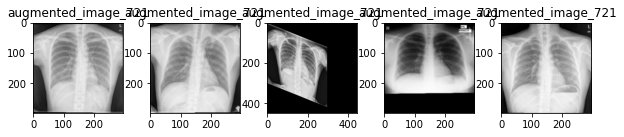

In [40]:
import glob
from PIL import Image
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob('base_dir/train_dir/Normal/augmented_image_*'):
    images.append(np.asarray(Image.open(f)))
    #images = Image.fromarray(f)

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names

for i in range(5):
    for filename in os.listdir('base_dir/train_dir/Normal/'):
      ClassName = filename[:-4]
      axs[i].imshow(images[i])
      axs[i].set_title(ClassName)
      



To plot the augmented images in Tuberculosis class

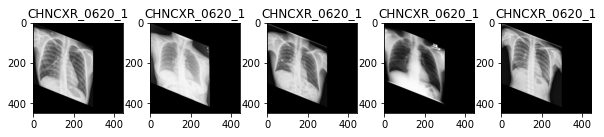

In [41]:
import glob
from PIL import Image
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob('base_dir/train_dir/Tuberculosis/augmented_image_*'):
    images.append(np.asarray(Image.open(f)))
    #images = Image.fromarray(f)

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names

for i in range(5):
    for filename in os.listdir('base_dir/train_dir/Tuberculosis/'):
      ClassName = filename[:-4]
      axs[i].imshow(images[i])
      axs[i].set_title(ClassName)
      

# Feature Extraction using CheXNet

In [42]:
import glob
import skimage

def loadImages(path):
    '''
        parameters
        ----------
        path : input path of the images
        
        returns
        -------
        loadedImages : list of loaded images 
    '''
    sample = []
    
    for filename in glob.glob(path):
        
        img = cv2.imread(filename)
        img = skimage.transform.resize(img, (224, 224, 3))        
        IMG = np.array(img,dtype=np.float64)
        
        
        sample.append(IMG)
        
    return sample

In [43]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

train_path1 = 'base_dir/train_dir/Normal/*.png'
train_path2 = 'base_dir/train_dir/Tuberculosis/*.png'
train_path3 = 'base_dir/train_dir/Normal/augmented_image_*'
train_path4 = 'base_dir/train_dir/Tuberculosis/augmented_image_*'

valid_path1 = 'base_dir/val_dir/Normal/*.png'
valid_path2 = 'base_dir/val_dir/Tuberculosis/*.png'

train_N = loadImages(train_path1)
train_TB = loadImages(train_path2)

train_N_aug = loadImages(train_path3) 
train_TB_aug= loadImages(train_path4)

valid_N = loadImages(valid_path1)
valid_TB = loadImages(valid_path2)

In [44]:
#%% CREATION OF DATASETS FOR FEATURE EXTRACTION

df_train_N = pd.DataFrame({'image':train_N, 'label': 'Normal'})
df_train_TB = pd.DataFrame({'image':train_TB, 'label': 'Tuberculosis'})
df_train_N_aug = pd.DataFrame({'image':train_N_aug, 'label': 'Normal'})
df_train_TB_aug = pd.DataFrame({'image':train_TB_aug, 'label': 'Tuberculosis'})


df_valid_N = pd.DataFrame({'image':valid_N, 'label': 'Normal'})
df_valid_TB = pd.DataFrame({'image':valid_TB, 'label': 'Tuberculosis'})

In [45]:
final_data = [df_train_N, df_train_TB, df_train_N_aug,df_train_TB_aug, df_valid_N, df_valid_TB]
final_data = pd.concat(final_data)

print("Entire data size:",final_data.shape)

Entire data size: (3802, 2)


In [46]:
temp_N = df_train_N_aug.head(9)
temp_N.shape

(9, 2)

In [47]:
temp_TB = df_train_TB_aug.head(9)
temp_TB.shape

(9, 2)

In [48]:
#%% CREATION OF DATASETS FOR FEATURE EXTRACTION

df_train_N = pd.DataFrame({'image':train_N, 'label': 'Normal'})
df_train_TB = pd.DataFrame({'image':train_TB, 'label': 'Tuberculosis'})
df_train_N_aug = pd.DataFrame({'image':train_N_aug, 'label': 'Normal'})
df_train_TB_aug = pd.DataFrame({'image':train_TB_aug, 'label': 'Tuberculosis'})


df_valid_N = pd.DataFrame({'image':valid_N, 'label': 'Normal'})
df_valid_TB = pd.DataFrame({'image':valid_TB, 'label': 'Tuberculosis'})

In [49]:
final_data = [temp_N,temp_TB,df_train_N_aug, df_train_TB_aug, df_valid_N, df_valid_TB]
final_data = pd.concat(final_data)

print("Entire data size:",final_data.shape)

Entire data size: (3140, 2)


In [50]:
#%% TRAIN LABEL SEPARATION

train_data = final_data['image']
labels = final_data['label']

In [51]:
#%% LOOKING AT THE AMOUNT OF ITEMS PER CLASS 

from collections import Counter
print("Labels Count:",Counter(np.array(labels)))

Labels Count: Counter({'Normal': 1571, 'Tuberculosis': 1569})


# label encoding

In [52]:
# ENCODING the LABELS

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

final_data['label'] = le.fit_transform(final_data['label'])
final_data.head()

,image,label
0,"[[[0.003921568646982494, 0.003921568646982494,...",0
1,"[[[0.10327380974738028, 0.10327380974738028, 0...",0
2,"[[[0.5171239820751061, 0.5171239820751061, 0.5...",0
3,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...",0
4,"[[[0.0431372549019608, 0.0431372549019608, 0.0...",0


In [53]:
#%% TRAIN LABEL SEPARATION

train_data = final_data['image']
labels = final_data['label']

In [54]:
#%% SPLITTING INTO TRAIN AND TEST SET, TRAIN SET WILL BE FURTHER SPLIT INTO TRAIN AND VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(train_data, labels,
                                                  test_size = 0.2,
                                                  stratify = labels,
                                                  shuffle = True,
                                                  random_state = 42)

print('length X_train:', len(X_train))
print('length y_train:', len(y_train))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 2512
length y_train: 2512
length X_test: 628
length y_test: 628


In [55]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [56]:

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [57]:
x_train= np.empty((len(X_train),X_train[0].shape[0],X_train[0].shape[1],X_train[0].shape[2]))
for i,x in enumerate(X_train):
    x_train[i]=X_train[i]
print(x_train.shape)

(2512, 224, 224, 3)


In [58]:
x_test= np.empty((len(X_test),X_test[0].shape[0],X_test[0].shape[1],X_test[0].shape[2]))
for i,x in enumerate(X_test):
    x_test[i]=X_test[i]
print(x_test.shape)

(628, 224, 224, 3)


# Feature Extraction

In [59]:
# for CheXNet.. 

from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [60]:
ChexNet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='max')

29097984/29084464 [==============================] - 0s 0us/step


In [61]:
ChexNet_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

# conv5_block3_concat layer

In [62]:
# summarize feature map shapes
for i in range(len(ChexNet_model.layers)):
    layer = ChexNet_model.layers[i]
# check for conv5_ layer
    if 'conv5_block3_concat' not in layer.name:
        continue
# summarize output shape
    print(i, layer.name, layer.output.shape)

333 conv5_block3_concat (None, 7, 7, 608)


In [63]:
# redefine model to output right after the 333th (conv5_block3_concat) layer
chex_feat_model = Model(inputs=ChexNet_model.inputs, outputs=ChexNet_model.layers[333].output)

In [64]:
# feature extraction train set using ChexNet
x_train_feat_chxnet = chex_feat_model.predict(x_train)

In [65]:
x_train_feat_chxnet.shape

(2512, 7, 7, 608)

In [66]:
# feature extraction train set using ChexNet
x_val_feat_chxnet = chex_feat_model.predict(x_test)

In [67]:
x_val_feat_chxnet.shape

(628, 7, 7, 608)

# Visualize conv5_block3_concat Layer features for the CheXNet

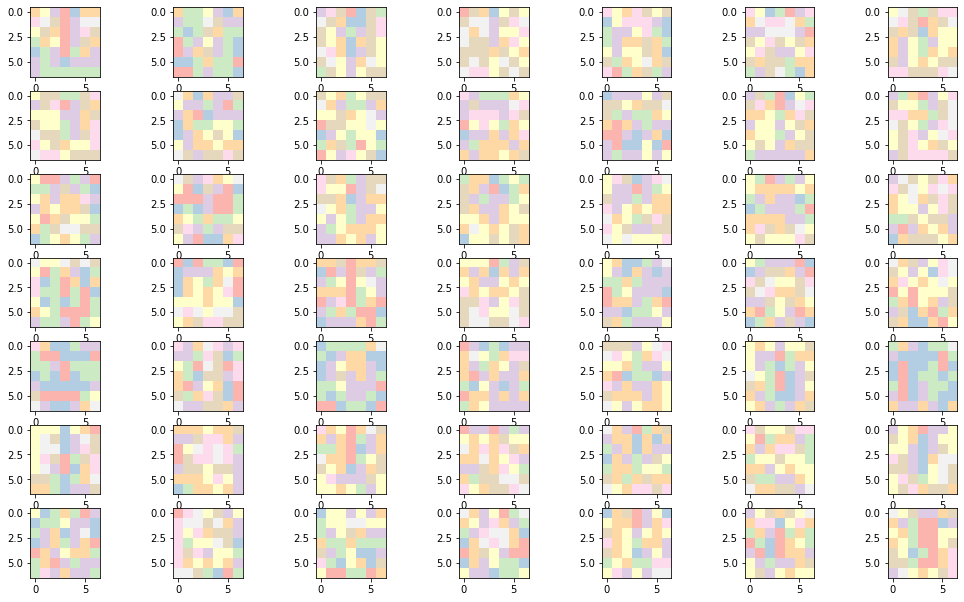

In [68]:
layer_outputs = [layer.output for layer in chex_feat_model.layers]
activation_model = Model(inputs = chex_feat_model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[10].reshape(1,224,224,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='Pastel1')
            activation_index += 1
# conv5_block3_concat
display_activation(activations, 7, 7, 333)

# Receptive Field Aware Network for classifying features from the CheXNet

In [69]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Activation

import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPool2D, Dropout, Activation, AvgPool2D
from keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam


import warnings
warnings.filterwarnings("ignore")

In [93]:
def tbmodel_chxnet_feat():    
    model = Sequential()
    model.add(Conv2D(7, (3, 3), padding='same', activation='relu', input_shape=(7,7,608)))
    model.add(Conv2D(7, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="sparse_categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])
        
    return model

The architecture of this model consists of a stack of convolutional layers, pooling layers, dropout layers, and dense layers. The first layer is a Conv2D layer with 7 filters of size 3x3 and a padding of 'same'. The activation function used is ReLU. The input shape of this layer is (7, 7, 608), which means that it expects inputs of shape 7x7 with 608 channels. The second layer is another Conv2D layer with 7 filters of size 3x3 and a ReLU activation function. This is followed by a MaxPooling2D layer with a pool size of 2x2. The Dropout layer with a rate of 0.25 is used to regularize the model. Next, the Flatten layer is used to convert the 2D output of the previous layer into a 1D feature vector. This is followed by a Dense layer with 512 units and a ReLU activation function. Another Dropout layer with a rate of 0.5 is used to regularize the model. Finally, there is a Dense layer with 2 units and a sigmoid activation function, which produces the final output of the model. The loss function used during training is sparse categorical cross-entropy, and the optimizer used is Adam.

In [95]:
model = tbmodel_chxnet_feat()

In [96]:
ChxClf = model.fit(x_train_feat_chxnet, y_train,
                batch_size=30, verbose=1, 
                 validation_data=(x_val_feat_chxnet,y_test), epochs=100) 

Epoch 1/100
84/84 [==============================] - 2s 16ms/step - loss: 0.6182 - accuracy: 0.6238 - val_loss: 0.4545 - val_accuracy: 0.8153
Epoch 2/100
84/84 [==============================] - 1s 12ms/step - loss: 0.4224 - accuracy: 0.8217 - val_loss: 0.3835 - val_accuracy: 0.8519
Epoch 3/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3401 - accuracy: 0.8615 - val_loss: 0.3254 - val_accuracy: 0.8790
Epoch 4/100
84/84 [==============================] - 1s 14ms/step - loss: 0.3050 - accuracy: 0.8873 - val_loss: 0.2986 - val_accuracy: 0.8822
Epoch 5/100
84/84 [==============================] - 1s 12ms/step - loss: 0.2798 - accuracy: 0.8909 - val_loss: 0.3069 - val_accuracy: 0.8854
Epoch 6/100
84/84 [==============================] - 1s 12ms/step - loss: 0.2497 - accuracy: 0.9053 - val_loss: 0.3357 - val_accuracy: 0.8583
Epoch 7/100
84/84 [==============================] - 1s 13ms/step - loss: 0.2078 - accuracy: 0.9232 - val_loss: 0.2307 - val_accuracy: 0.9140
Epoch 

# Loss & Accuracy Curve

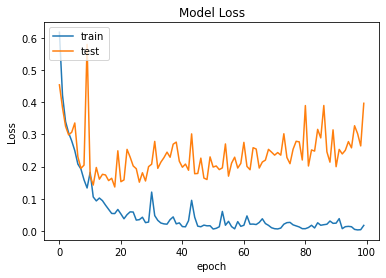

In [97]:
# summarize history for Loss
plt.plot(ChxClf.history["loss"])
plt.plot(ChxClf.history["val_loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

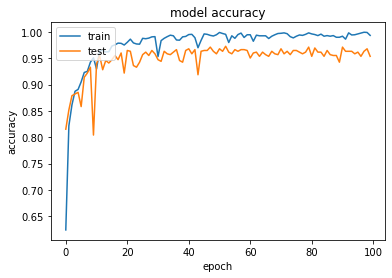

In [98]:
# summarize history for accuracy
plt.plot(ChxClf.history['accuracy'])
plt.plot(ChxClf.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [99]:
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred_chx = model.predict(x_val_feat_chxnet)

In [100]:
# Convert predictions classes to one hot vectors 
Y_pred_classes_chx = np.argmax(Y_pred_chx,axis = 1) 

In [101]:
from sklearn.metrics import accuracy_score # metrics
print(accuracy_score(y_test, Y_pred_classes_chx))

0.9538216560509554


In [102]:
# compute the confusion matrix
confusion_mtx_CheXNet_Clf = confusion_matrix(y_test, Y_pred_classes_chx) 
confusion_mtx_CheXNet_Clf


array([[308,   6],
       [ 23, 291]])

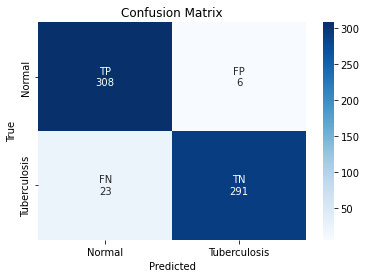

In [105]:

# Define class names
class_names = ['Normal', 'Tuberculosis']

# Compute confusion matrix
confusion_mtx_CheXNet_Clf = confusion_matrix(y_test, Y_pred_classes_chx)

# Define labels for each cell in the confusion matrix
tp = confusion_mtx_CheXNet_Clf[0, 0]
fp = confusion_mtx_CheXNet_Clf[0, 1]
fn = confusion_mtx_CheXNet_Clf[1, 0]
tn = confusion_mtx_CheXNet_Clf[1, 1]
labels = np.asarray([f"TP\n{tp}", f"FP\n{fp}", f"FN\n{fn}", f"TN\n{tn}"]).reshape(2, 2)

# Create heatmap with labels
sns.heatmap(confusion_mtx_CheXNet_Clf, annot=labels, fmt="", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels for axes and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [106]:
chx_pred_probabilities = model.predict_generator(x_val_feat_chxnet)
chx_pred_probabilities

array([[9.9583006e-01, 4.5028329e-03],
       [9.9926847e-01, 7.5653195e-04],
       [3.0782971e-07, 9.9999964e-01],
       ...,
       [9.9819463e-01, 1.9282401e-03],
       [9.9939251e-01, 5.9136748e-04],
       [1.3884902e-04, 9.9985504e-01]], dtype=float32)

## saving ChexNet feat classifier predictions to a dataframe

In [107]:
df_Y_pred_classes_chx  = pd.DataFrame(Y_pred_classes_chx, columns =['pred_class_chx'])
df_Y_pred_classes_chx.to_csv('pred_chx.csv', index=None) 

# saving the model 

In [108]:
model.save("ChexNet_feat_CLF_model.h5")


# ------------------------------------------------------------------------------------------

# Feature Extraction using DenseNet 169

In [109]:
import tensorflow 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169

from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [110]:
# Instantiate convolutional base of DenseNet 169

dense169_model = DenseNet169(weights='imagenet', 
                  include_top=False,
                  input_shape=(224,224, 3))

# Show architecture
dense169_model.summary()

51888128/51877672 [==============================] - 0s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________

# conv5_block32_concat   Layer

In [111]:
# in paper - conv5_block32_concat

In [112]:
# summarize feature map shapes
for i in range(len(dense169_model.layers)):
    layer = dense169_model.layers[i]
# check for conv5_ layer
    if 'conv5_block32_concat' not in layer.name:
        continue
# summarize output shape
    print(i, layer.name, layer.output.shape)

592 conv5_block32_concat (None, 7, 7, 1664)


In [113]:
# redefine model to output right after the 592nd (conv5_block3_concat) layer
dense169_feat_model = Model(inputs=dense169_model.inputs, outputs=dense169_model.layers[592].output)

In [114]:
# feature extraction train set using DenseNet169
x_train_feat_dense169 = dense169_feat_model.predict(x_train)

In [115]:
x_train_feat_dense169.shape

(2512, 7, 7, 1664)

In [116]:
# feature extraction train set using DenseNet169
x_val_feat_dense169 = dense169_feat_model.predict(x_test)

In [117]:
x_val_feat_dense169.shape

(628, 7, 7, 1664)

# Visualizing the feature maps at  conv5_block32_concat layer of DenseNet169

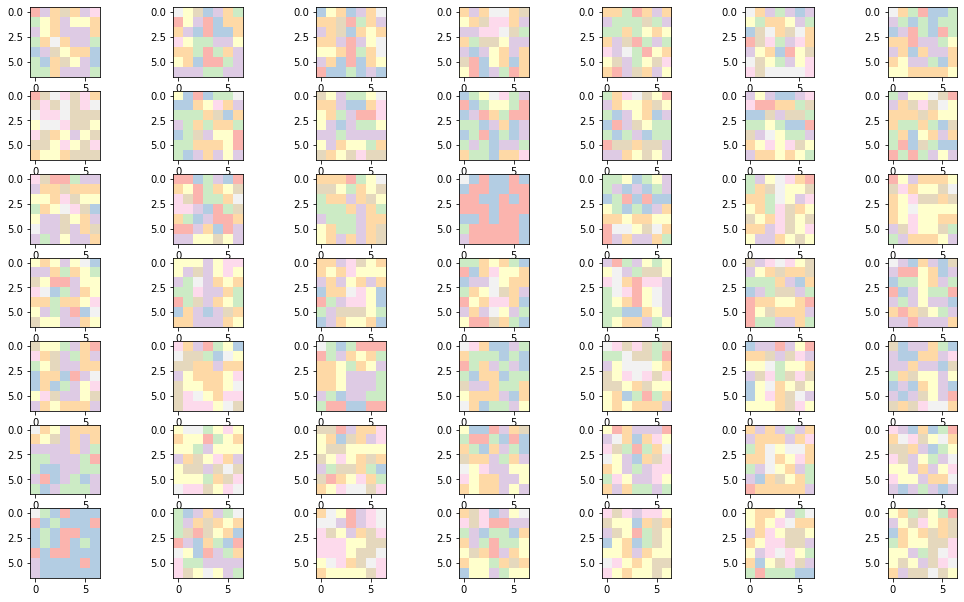

In [118]:

layer_outputs = [layer.output for layer in dense169_model.layers]
activation_model = Model(inputs = dense169_model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[10].reshape(1,224,224,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size): # (row_size*100,col_size*10.5)
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='Pastel1')
            activation_index += 1
#  conv5_block32_concat
display_activation(activations, 7, 7, 592)

# Neural Network for classifying features extracted by DenseNet169 

In [119]:
def tbmodel_4densenet_feat():    
    model = Sequential()
    model.add(Conv2D(7, (3, 3), padding='same', activation='relu', input_shape=(7,7,1664)))
    model.add(Conv2D(7, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="sparse_categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])
    
    return model

In [122]:
model = tbmodel_4densenet_feat()

In [123]:
Classifier_denseNetFeat = model.fit(x_train_feat_dense169, y_train,
                batch_size=30, verbose=1, 
                 validation_data=(x_val_feat_dense169, y_test), epochs=100)

Epoch 1/100
84/84 [==============================] - 3s 28ms/step - loss: 0.5982 - accuracy: 0.6596 - val_loss: 0.4477 - val_accuracy: 0.8169
Epoch 2/100
84/84 [==============================] - 2s 24ms/step - loss: 0.3792 - accuracy: 0.8471 - val_loss: 0.3592 - val_accuracy: 0.8487
Epoch 3/100
84/84 [==============================] - 2s 24ms/step - loss: 0.3093 - accuracy: 0.8718 - val_loss: 0.3161 - val_accuracy: 0.8694
Epoch 4/100
84/84 [==============================] - 2s 28ms/step - loss: 0.2755 - accuracy: 0.8953 - val_loss: 0.3097 - val_accuracy: 0.8869
Epoch 5/100
84/84 [==============================] - 3s 29ms/step - loss: 0.2049 - accuracy: 0.9271 - val_loss: 0.2681 - val_accuracy: 0.8965
Epoch 6/100
84/84 [==============================] - 2s 24ms/step - loss: 0.1907 - accuracy: 0.9299 - val_loss: 0.2450 - val_accuracy: 0.9061
Epoch 7/100
84/84 [==============================] - 2s 24ms/step - loss: 0.1400 - accuracy: 0.9490 - val_loss: 0.2372 - val_accuracy: 0.9156
Epoch 

# Loss & Accuracy Curves for DenseNet Feature Classifier

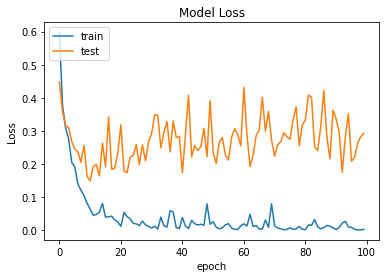

In [124]:
# summarize history for Loss
plt.plot(Classifier_denseNetFeat.history["loss"])
plt.plot(Classifier_denseNetFeat.history["val_loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

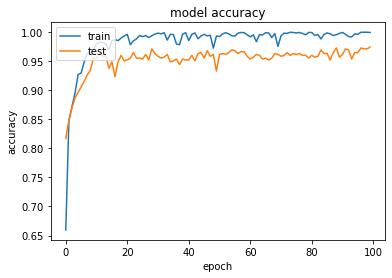

In [125]:
# summarize history for accuracy
plt.plot(Classifier_denseNetFeat.history['accuracy'])
plt.plot(Classifier_denseNetFeat.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

# Prediction for features from DenseNet

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [127]:

# Predict the values from the validation dataset
Y_pred_dense169 = model.predict(x_val_feat_dense169)

In [128]:
# Convert predictions classes to one hot vectors 
Y_pred_classes_dense169 = np.argmax(Y_pred_dense169,axis = 1) 

In [129]:
from sklearn.metrics import accuracy_score # metrics
print(accuracy_score(y_test, Y_pred_classes_dense169))

0.9745222929936306


In [130]:
# compute the confusion matrix
confusion_mtx_DenseNet_Clf = confusion_matrix(y_test, Y_pred_classes_dense169) 
confusion_mtx_DenseNet_Clf

array([[304,  10],
       [  6, 308]])

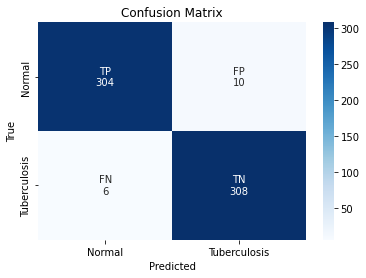

In [132]:

# Define class names
class_names = ['Normal', 'Tuberculosis']

# Compute confusion matrix
confusion_mtx_DenseNet_Clf = confusion_matrix(y_test, Y_pred_classes_dense169)

# Define labels for each cell in the confusion matrix
tp = confusion_mtx_DenseNet_Clf[0, 0]
fp = confusion_mtx_DenseNet_Clf[0, 1]
fn = confusion_mtx_DenseNet_Clf[1, 0]
tn = confusion_mtx_DenseNet_Clf[1, 1]
labels = np.asarray([f"TP\n{tp}", f"FP\n{fp}", f"FN\n{fn}", f"TN\n{tn}"]).reshape(2, 2)

# Create heatmap with labels
sns.heatmap(confusion_mtx_DenseNet_Clf, annot=labels, fmt="", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels for axes and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [133]:
den_pred_probabilities = model.predict_generator(x_val_feat_dense169)
den_pred_probabilities

array([[5.1237619e-01, 4.5004556e-01],
       [9.9987495e-01, 9.5700896e-05],
       [2.3143329e-10, 1.0000000e+00],
       ...,
       [9.9630344e-01, 3.0182600e-03],
       [1.5981528e-01, 8.1517053e-01],
       [1.6527385e-06, 9.9999678e-01]], dtype=float32)

## saving Densenet feat classifier predictions to a dataframe

In [134]:
df_Y_pred_classes_dense169  = pd.DataFrame(Y_pred_classes_dense169, columns =['pred_class_dense'])
df_Y_pred_classes_dense169.to_csv('pred_dense.csv', index=None)

#saving the densenet169 features classifier model

In [135]:
model.save("densenet_feat_CLF_model.h5")


# Classification Network for Features extracted from Inception Net

In [136]:
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Activation

import tensorflow as tf
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv3D, Flatten, MaxPool2D, Dropout, Activation, AvgPool2D
from keras.preprocessing.image import img_to_array, ImageDataGenerator, load_img
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings("ignore")

In [137]:
def tbInpmodel():    
    model = Sequential()
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(8,8,192)))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))   
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(loss="sparse_categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])   
    return model

model = tbInpmodel()

In [138]:
# Load npz file containing image arrays
x_train_feat_inp = np.load("/kaggle/input/inception-net-features-for-TBproject/x_train_feat_inp.npy")
#x_train_feat_inp 

In [139]:
# Load npz file containing image arrays
x_val_feat_inp = np.load("/kaggle/input/inception-net-features-for-TBproject/x_val_feat_inp.npy")


In [140]:
x_val_feat_inp.shape

(628, 8, 8, 192)

In [141]:
InpClf = model.fit(x_train_feat_inp, y_train,
                batch_size=30, verbose=1, 
                 validation_data=(x_val_feat_inp,y_test), epochs=100) 

Epoch 1/100
84/84 [==============================] - 1s 10ms/step - loss: 0.5807 - accuracy: 0.6883 - val_loss: 0.5107 - val_accuracy: 0.7707
Epoch 2/100
84/84 [==============================] - 1s 7ms/step - loss: 0.4248 - accuracy: 0.8169 - val_loss: 0.4787 - val_accuracy: 0.8057
Epoch 3/100
84/84 [==============================] - 1s 7ms/step - loss: 0.3567 - accuracy: 0.8499 - val_loss: 0.4287 - val_accuracy: 0.8185
Epoch 4/100
84/84 [==============================] - 1s 8ms/step - loss: 0.2891 - accuracy: 0.8850 - val_loss: 0.4067 - val_accuracy: 0.8312
Epoch 5/100
84/84 [==============================] - 1s 7ms/step - loss: 0.2562 - accuracy: 0.9009 - val_loss: 0.4473 - val_accuracy: 0.8439
Epoch 6/100
84/84 [==============================] - 1s 7ms/step - loss: 0.2144 - accuracy: 0.9196 - val_loss: 0.3650 - val_accuracy: 0.8678
Epoch 7/100
84/84 [==============================] - 1s 7ms/step - loss: 0.1779 - accuracy: 0.9299 - val_loss: 0.3935 - val_accuracy: 0.8694
Epoch 8/100


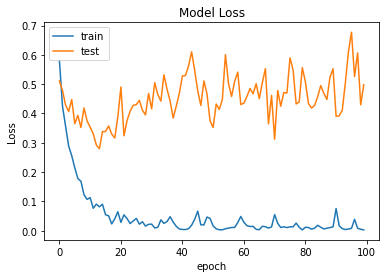

In [142]:
# summarize history for Loss
plt.plot(InpClf.history["loss"])
plt.plot(InpClf.history["val_loss"])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

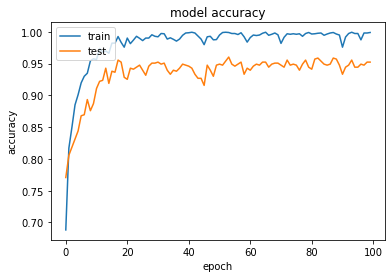

In [143]:
# summarize history for accuracy
plt.plot(InpClf.history['accuracy'])
plt.plot(InpClf.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction of Inception Net Classifier

In [145]:
len(x_val_feat_inp)

628

In [146]:
# Predict the values from the validation dataset
Y_pred_inp = model.predict(x_val_feat_inp)
Y_pred_inp

array([[2.9855648e-06, 9.9997878e-01],
       [1.0000000e+00, 2.5312472e-09],
       [1.9044578e-03, 9.9635577e-01],
       ...,
       [9.9999249e-01, 4.0599551e-07],
       [1.4628327e-01, 7.4946386e-01],
       [7.6227784e-03, 9.7864795e-01]], dtype=float32)

In [147]:
# Convert predictions classes to one hot vectors 
Y_pred_classes_inp = np.argmax(Y_pred_inp,axis = 1) 
Y_pred_classes_inp

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,

In [148]:
# compute the confusion matrix
confusion_mtx_inp = confusion_matrix(y_test, Y_pred_classes_inp)
print("confusion matrix: ")
print(confusion_mtx_inp)

confusion matrix: 
[[307   7]
 [ 23 291]]


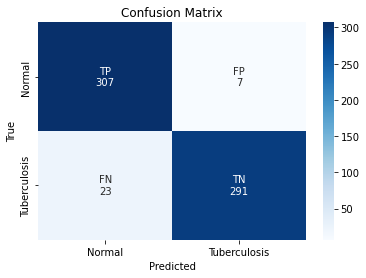

In [150]:
# Define class names
class_names = ['Normal', 'Tuberculosis']

# Compute confusion matrix
confusion_mtx_inp = confusion_matrix(y_test, Y_pred_classes_inp)

# Define labels for each cell in the confusion matrix
tp = confusion_mtx_inp[0, 0]
fp = confusion_mtx_inp[0, 1]
fn = confusion_mtx_inp[1, 0]
tn = confusion_mtx_inp[1, 1]
labels = np.asarray([f"TP\n{tp}", f"FP\n{fp}", f"FN\n{fn}", f"TN\n{tn}"]).reshape(2, 2)

# Create heatmap with labels
sns.heatmap(confusion_mtx_inp, annot=labels, fmt="", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add labels for axes and title
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [151]:
from sklearn.metrics import confusion_matrix, accuracy_score # metrics
print(accuracy_score(y_test, Y_pred_classes_inp))

0.9522292993630573


In [152]:
inp_pred_probabilities = model.predict_generator(x_val_feat_inp)
inp_pred_probabilities

array([[2.9855648e-06, 9.9997878e-01],
       [1.0000000e+00, 2.5312472e-09],
       [1.9044578e-03, 9.9635577e-01],
       ...,
       [9.9999249e-01, 4.0599551e-07],
       [1.4628327e-01, 7.4946386e-01],
       [7.6227784e-03, 9.7864795e-01]], dtype=float32)

## saving InceptionNet feature classifier predictions to dataframe

In [153]:
df_Y_pred_classes_inp = pd.DataFrame(Y_pred_classes_inp, columns =['pred_class_inp'])
df_Y_pred_classes_inp

,pred_class_inp
0,1
1,0
2,1
3,0
4,0
...,...
623,1
624,1
625,0
626,1


# saving the Inception Net features Classification Model

In [154]:
model.save("Inception_feat_CLF_model.h5")


#  **** Ensembling ****

# Loading Logistic regression classifier's predictions

## HOG probabilities

In [155]:
# Load npz file 
LR_HOG_Proba = np.load("/kaggle/input/hog-lr-proba-pred/logit_preds_prob_HOG_val.npy")
LR_HOG_Proba 

array([[0.19284642, 0.80715358],
       [0.9378059 , 0.0621941 ],
       [0.23461089, 0.76538911],
       ...,
       [0.81392606, 0.18607394],
       [0.10688742, 0.89311258],
       [0.1525434 , 0.8474566 ]])

# GIST probabilities

In [156]:
# Load npz file 
LR_GIST_Proba = np.load('/kaggle/input/gist-lr-proba-pred/logit_preds_prob_GIST_val.npy')
LR_GIST_Proba 

array([[0.07934347, 0.92065653],
       [0.72304264, 0.27695736],
       [0.91274446, 0.08725554],
       ...,
       [0.72661805, 0.27338195],
       [0.62359445, 0.37640555],
       [0.57237371, 0.42762629]])

## Load the prediction class of the feature HOG - LR classifier 

In [157]:
Y_pred_classes_LR_Clf_HOG = np.loadtxt('/kaggle/input/lr-tbproject-noheader/LR _TB - pred_class_LogisticRegClf.csv')
Y_pred_classes_LR_Clf_HOG 

array([1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1.

In [158]:
Y_pred_classes_LR_Clf_HOG = Y_pred_classes_LR_Clf_HOG.astype(int)
Y_pred_classes_LR_Clf_HOG

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,

In [159]:
Y_pred_classes_LR_Clf_GIST = np.loadtxt('/kaggle/input/no-header-pred-class-gist-lr/GIST LR TB - pred_class_GIST_LRClf.csv')
Y_pred_classes_LR_Clf_GIST

array([1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 1., 1.

# Ensemble with Logistic regression Classifier (Hand Engineered features only)

In [160]:
import numpy as np

# model_predictions is a list of predictions from multiple models
model_predictions = [Y_pred_classes_LR_Clf_HOG , Y_pred_classes_LR_Clf_GIST]

# Stack the predictions along axis=0
ensemble1_prediction = np.stack(model_predictions, axis=0)

# Check the number of dimensions of the ensemble_prediction array
if ensemble1_prediction.ndim == 1:
    ensemble1_prediction = ensemble1_prediction[0]
else:
    # Take the mean of the stacked predictions along axis=0
    ensemble1_prediction = np.mean(ensemble1_prediction, axis=0)

# Convert the average predictions back to the original format
ensemble1_prediction = ensemble1_prediction.flatten()

# Convert the predicted class probabilities into actual class labels
ensemble1_prediction = np.round(ensemble1_prediction).astype(int)


Here, model_predictions is a list of predictions from each of the two Habd Crafted features Logistic regression classifier (ML) models. The predictions are stacked along axis=0 using np.stack which creates a 2D array of shape (num_models, num_samples).

If the dimension of this array is 1, it means that there was only one model and hence we take the first element of the array. If not, we take the mean of the stacked predictions along the axis=0 to get the average prediction of all models.

The average prediction is then converted back to the original format by flattening the array. Finally, the predicted class probabilities are converted into actual class labels by rounding off the probabilities and casting them into integers.

# Ensemble with features extracted from three Deep Learning models

In [161]:
# model_predictions is a list of predictions from multiple models
model_predictions = [Y_pred_classes_chx , Y_pred_classes_dense169 , Y_pred_classes_inp]

# Stack the predictions along axis=0
ensemble2_prediction = np.stack(model_predictions, axis=0)

# Check the number of dimensions of the ensemble_prediction array
if ensemble2_prediction.ndim == 1:
    ensemble2_prediction = ensemble2_prediction[0]
else:
    # Take the mean of the stacked predictions along axis=0
    ensemble2_prediction = np.mean(ensemble2_prediction, axis=0)

# Convert the average predictions back to the original format
ensemble2_prediction = ensemble2_prediction.flatten()

# Convert the predicted class probabilities into actual class labels
ensemble2_prediction = np.round(ensemble2_prediction).astype(int)


Here, model_predictions is a list of predictions from each of the 3 deep learning models. The predictions are stacked along axis=0 using np.stack which creates a 2D array of shape (num_models, num_samples).

If the dimension of this array is 1, it means that there was only one model and hence we take the first element of the array. If not, we take the mean of the stacked predictions along the axis=0 to get the average prediction of all models.

The average prediction is then converted back to the original format by flattening the array. Finally, the predicted class probabilities are converted into actual class labels by rounding off the probabilities and casting them into integers.

# Ensemble with Logistic regression Classifier and the Deep Learning models

In [162]:
# model_predictions is a list of predictions from multiple models
model_predictions = [Y_pred_classes_chx , Y_pred_classes_dense169 , Y_pred_classes_inp , Y_pred_classes_LR_Clf_HOG , Y_pred_classes_LR_Clf_GIST]

# Stack the predictions along axis=0
ensemble3_prediction = np.stack(model_predictions, axis=0)

# Check the number of dimensions of the ensemble_prediction array
if ensemble3_prediction.ndim == 1:
    ensemble3_prediction = ensemble3_prediction[0]
else:
    # Take the mean of the stacked predictions along axis=0
    ensemble3_prediction = np.mean(ensemble3_prediction, axis=0)

# Convert the average predictions back to the original format
ensemble3_prediction = ensemble3_prediction.flatten()

# Convert the predicted class probabilities into actual class labels
ensemble3_prediction = np.round(ensemble3_prediction).astype(int)


Here, model_predictions is a list of predictions from each of the 5 models. The predictions are stacked along axis=0 using np.stack which creates a 2D array of shape (num_models, num_samples).

If the dimension of this array is 1, it means that there was only one model and hence we take the first element of the array. If not, we take the mean of the stacked predictions along the axis=0 to get the average prediction of all models.

The average prediction is then converted back to the original format by flattening the array. Finally, the predicted class probabilities are converted into actual class labels by rounding off the probabilities and casting them into integers.

# Evaluate the performance

In [163]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each ensemble model
ensemble1_accuracy = accuracy_score(y_test, ensemble1_prediction)
ensemble2_accuracy = accuracy_score(y_test, ensemble2_prediction)
ensemble3_accuracy = accuracy_score(y_test, ensemble3_prediction)

# Print the accuracy of each ensemble model
print("Accuracy of Ensemble 1 - Hand Engineered Ensemble: ", ensemble1_accuracy)
print("Accuracy of Ensemble 2 - Deep Learned Ensemble: ", ensemble2_accuracy)
print("Accuracy of Ensemble 3 - Hand Engineered & Deep Learned Ensemble : ", ensemble3_accuracy)

# Find the ensemble model with the highest accuracy
best_ensemble = np.argmax([ensemble1_accuracy, ensemble2_accuracy, ensemble3_accuracy])
print("Best Ensemble Model: ", best_ensemble + 1)


Accuracy of Ensemble 1 - Hand Engineered Ensemble:  0.8264331210191083
Accuracy of Ensemble 2 - Deep Learned Ensemble:  0.9792993630573248
Accuracy of Ensemble 3 - Hand Engineered & Deep Learned Ensemble :  0.9840764331210191
Best Ensemble Model:  3


The 1 is added to the best ensemble to make the indexing match the actual ensemble model number. In Python, the indexing starts from 0, so adding 1 ensures that the ensemble model number matches the actual number (i.e., if the best ensemble is Ensemble 1, the index is 0, but the printed output should say "Best Ensemble Model: 1"). By adding 1, the code maps the index to the actual number of the ensemble model, which makes the output easier to understand.

## Thus as said in the research paper, the ML-DL Ensemble performs the best.